<a href="https://colab.research.google.com/github/GeoLinkCoding/EarthResources_DataScience/blob/main/Regression/Notebooks/Regression_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression EDA

### Introduction

Forecasting river discharge can be useful for flood preparation, water resource management, environmental protection, and more. Machine learning models present an improvement to typical physics based hydrological models by learning complex patterns, handling noisy data, and adapting to changing river conditions. Simple models like linear regression can be used for general patterns while more advanced models like xg boost can interpret more complex patterns. We'll explore these models for data retrieved from three different sites along the Colorado River. The first site is in Glenwood Springs, CO, a fairly populated location with a metro population of nearly 80k and annual tourism of over 1 million visitors. Conversely, the second site is in a remote national conservation area right at the Colorado-Utah border. The last site is right in the middle of the Grand Canyon, giving a good range of differing conditions that can present unique discharge patterns to compare forecasting performances. Discharge is measured in cubic feet per second and is collected every hour. The datasets used here range in time from the beginning of 2016 to the end of 2024.

### EDA

We start by retrieving the data for the three sites in the chosen time range.

In [1]:
!pip install dataretrieval

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Import dataretrieval for accessing environmental data from various sources
import dataretrieval.nwis as nwis
# Colorado river
site = ['09085100', # below glenwood springs, co
        '09163500', # near colorado-utah border
        '09402500'] # near grand canyon, az
# get instantaneous values (iv)
df = nwis.get_record(sites=site, service='iv', start='2016-1-01', end='2024-12-30')

# Want some metadata
df_site = nwis.get_record(sites=site, service='site')

In [3]:
df_query = df['00060'].dropna().reset_index()
df_resample = df_query.groupby('site_no').resample('60min', on='datetime')['00060'].mean().reset_index()
df_resample = df_resample.set_index(['site_no', 'datetime'])
df_resample = df_resample.rename(columns={'00060': 'Discharge'})
site_names = {
    '09085100': 'Glenwood Springs',
    '09163500': 'CO-UT Border',
    '09402500': 'Grand Canyon'
}
df_resample.index = df_resample.index.set_levels(df_resample.index.levels[0].map(site_names.get), level=0)
df_resample

Discharge
site_no          datetime                            
Glenwood Springs 2016-01-01 07:00:00+00:00     1245.0
                 2016-01-01 08:00:00+00:00     1250.0
                 2016-01-01 09:00:00+00:00     1250.0
                 2016-01-01 10:00:00+00:00     1240.0
                 2016-01-01 11:00:00+00:00     1232.5
...                                               ...
Grand Canyon     2024-12-31 02:00:00+00:00     9870.0
                 2024-12-31 03:00:00+00:00     9745.0
                 2024-12-31 04:00:00+00:00     9572.5
                 2024-12-31 05:00:00+00:00     9350.0
                 2024-12-31 06:00:00+00:00     9102.5

[236544 rows x 1 columns]

In [4]:
df_site

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,09085100,"COLORADO RIVER BELOW GLENWOOD SPRINGS, CO",ST,393318,1072013,39.554982,-107.337554,M,F,...,NaN,NYNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-107.33755 39.55498)
1,USGS,09163500,COLORADO RIVER NEAR COLORADO-UTAH STATE LINE,ST,390758,1090135,39.132760,-109.027055,M,S,...,NaN,NYNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,460800110.0,POINT (-109.02705 39.13276)
2,USGS,09402500,"COLORADO RIVER NEAR GRAND CANYON, AZ",ST,360605,1120508,36.101372,-112.086280,M,T,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-112.08628 36.10137)


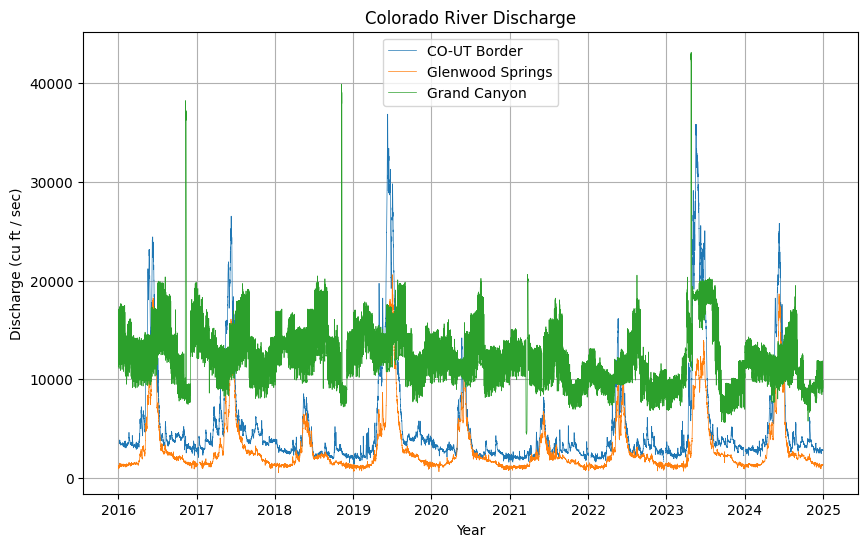

In [5]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

# Plot each site's discharge
for site_no, group in df_resample.groupby(level='site_no'):
    ax.plot(group.index.get_level_values('datetime'), group['Discharge'], label=site_no, linewidth=0.5)

# Set the title, labels, and grid
ax.set_title('Colorado River Discharge')
ax.set_xlabel('Year')
ax.set_ylabel('Discharge (cu ft / sec)')
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

**Figure 1.** Discharge over the whole time period. There are seasonal patterns visible as well as two spikes in mid 2019 and 2023.

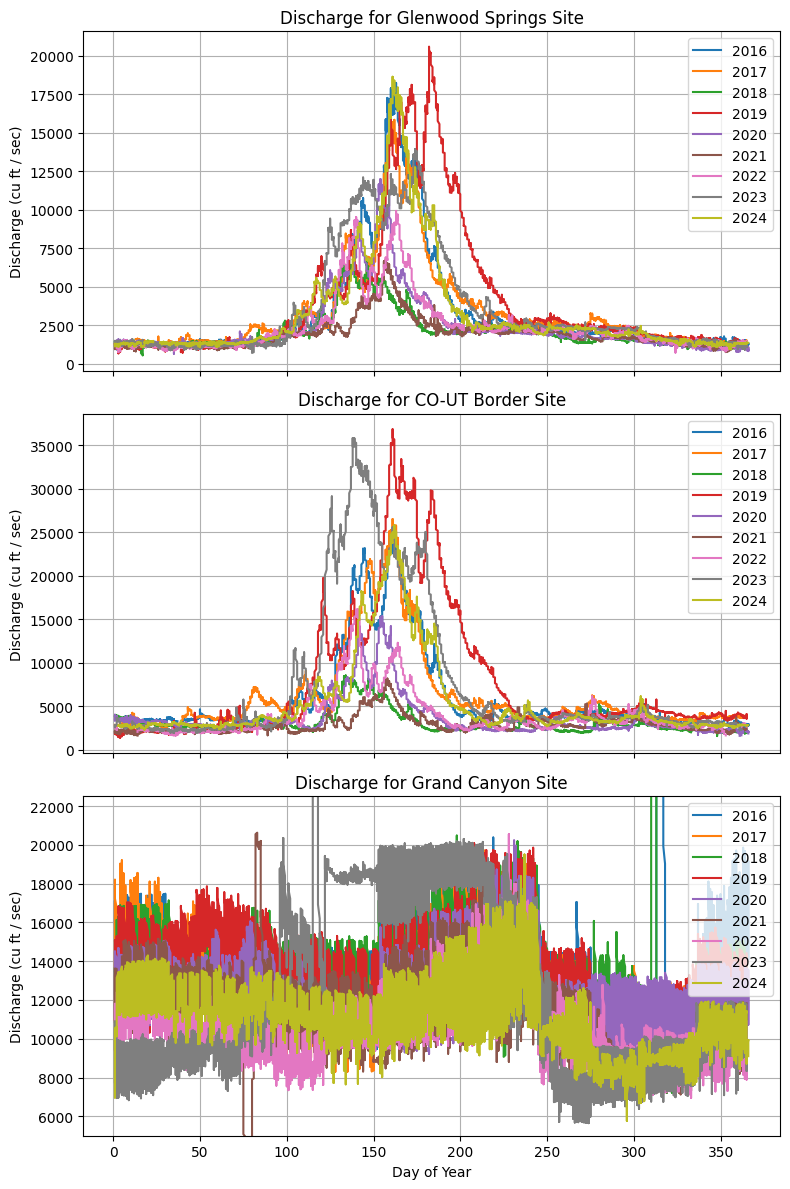

In [6]:
site_names = df_resample.index.get_level_values(0).unique()

# Create subplots for each site
fig, axes = plt.subplots(len(site_names), 1, figsize=(8, 4 * len(site_names)), sharex=True)

# Iterate over sites and plot data
for i, site_name in enumerate(site_names):
    site_data = df_resample.loc[site_name]

    # Group by year and plot each year's data
    for year, group in site_data.groupby(pd.Grouper(freq='YE')):
        # Access the dayofyear directly from the index
        axes[i].plot(group.index.dayofyear, group['Discharge'], label=year.year)

    axes[i].set_title(f'Discharge for {site_name} Site')
    axes[i].set_ylabel('Discharge (cu ft / sec)')
    axes[i].legend()
    axes[i].grid(True)
axes[2].set_ylim([5000, 22500])
# Set overall x-axis label
plt.xlabel('Day of Year')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Figure 2.** Yearly discharge for each site. Discharge rates increase in the middle of the year. The Glenwood and Colorado-Utah sites show similar curves but the Grand Canyon site is quite different. We'll explore this further below.

<ipython-input-7-e242d4932e8a>:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  for year, group in june_data_range.groupby(pd.Grouper(freq='Y')):


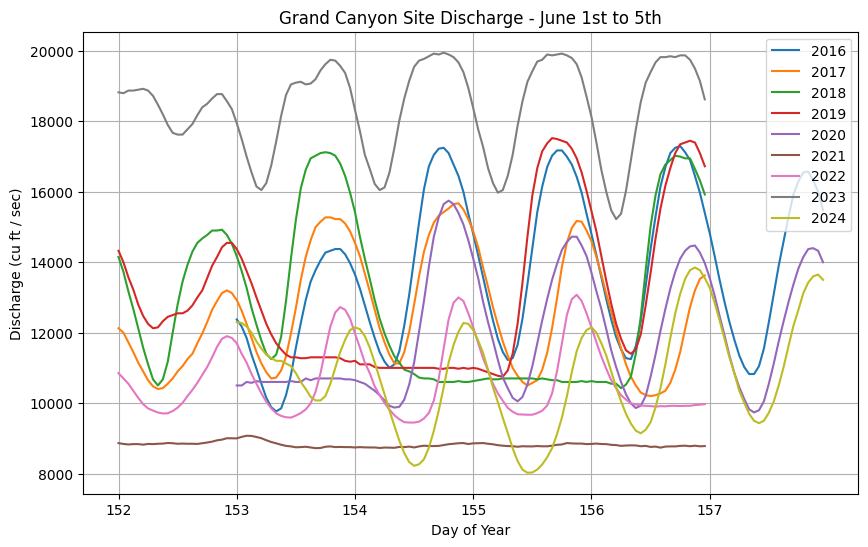

In [7]:
grand_canyon_data = df_resample.loc['Grand Canyon']
june_data_range = grand_canyon_data[
    (grand_canyon_data.index.get_level_values(0).month == 6) &
    (grand_canyon_data.index.get_level_values(0).day >= 1) &
    (grand_canyon_data.index.get_level_values(0).day <= 5)
]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by year and plot hourly data
for year, group in june_data_range.groupby(pd.Grouper(freq='Y')):
    # Create a continuous x-axis using dayofyear and hour
    x_values = group.index.dayofyear + group.index.hour / 24.0
    ax.plot(x_values, group['Discharge'], label=year.year)

# Customize the plot
ax.set_title('Grand Canyon Site Discharge - June 1st to 5th')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Discharge (cu ft / sec)')
ax.legend()
ax.grid(True)

# Set x-axis ticks and labels to represent days of June
xticks = np.arange(june_data_range.index.dayofyear.min(), june_data_range.index.dayofyear.max() + 1)
xticklabels = np.arange(1, 6)  # Days 1 to 5
ax.set_xticks(xticks)

# Show the plot
plt.show()

**Figure 3.** Discharge at the Grand Canyon for June 1st-5th of each year. Discharge rates change vastly over the course of a day.

In [8]:
for site_name, site_data in df_resample.groupby(level='site_no'):
    print(f"Descriptive statistics for {site_name} Site:")
    print(f'Shape - {site_data.shape}')
    print(site_data['Discharge'].describe())
    print("\n")

Descriptive statistics for CO-UT Border Site:
Shape - (78768, 1)
count    77591.000000
mean      5221.291129
std       5250.173029
min       1382.500000
25%       2690.000000
50%       3405.000000
75%       4640.000000
max      36850.000000
Name: Discharge, dtype: float64


Descriptive statistics for Glenwood Springs Site:
Shape - (78888, 1)
count    78471.000000
mean      2953.977682
std       2909.336840
min        545.250000
25%       1365.000000
50%       1967.500000
75%       2760.000000
max      20600.000000
Name: Discharge, dtype: float64


Descriptive statistics for Grand Canyon Site:
Shape - (78888, 1)
count    78888.000000
mean     12305.359867
std       3148.906735
min       4442.500000
25%      10150.000000
50%      11875.000000
75%      13850.000000
max      43075.000000
Name: Discharge, dtype: float64




Each site has close to 79k data points in it's dataset. A notable observation in the dataset statistics shows the Colorado River sees the highest discharge rates in the Grand Canyon.

In [9]:
site_names = df_resample.index.get_level_values(0).unique()
site_dfs = {}

for site_name in site_names:
    site_data = df_resample.loc[site_name]
    site_data = site_data.reset_index()
    site_data = site_data.set_index('datetime')
    site_dfs[site_name] = site_data

# Access each DataFrame using its site name:
gs_df = site_dfs['Glenwood Springs']
cu_df = site_dfs['CO-UT Border']
gc_df = site_dfs['Grand Canyon']

In [10]:
def add_seasonal(df):
    df["month"] = df.index.month
    df["day_of_year"] = df.index.dayofyear
    df["hour"] = df.index.hour

    df["season"] = df["month"].map({12: "Winter", 1: "Winter", 2: "Winter",
                                3: "Spring", 4: "Spring", 5: "Spring",
                                6: "Summer", 7: "Summer", 8: "Summer",
                                9: "Fall", 10: "Fall", 11: "Fall"})
    df["season_num"] = df["season"].map({"Winter": 1, "Spring": 2, "Summer": 3, "Fall": 4})
    return df

In [11]:
gs_df = add_seasonal(gs_df)
cu_df = add_seasonal(cu_df)
gc_df = add_seasonal(gc_df)

gs_df.head()

,Discharge,month,day_of_year,hour,season,season_num
datetime,,,,,,
2016-01-01 07:00:00+00:00,1245.0,1,1,7,Winter,1
2016-01-01 08:00:00+00:00,1250.0,1,1,8,Winter,1
2016-01-01 09:00:00+00:00,1250.0,1,1,9,Winter,1
2016-01-01 10:00:00+00:00,1240.0,1,1,10,Winter,1
2016-01-01 11:00:00+00:00,1232.5,1,1,11,Winter,1


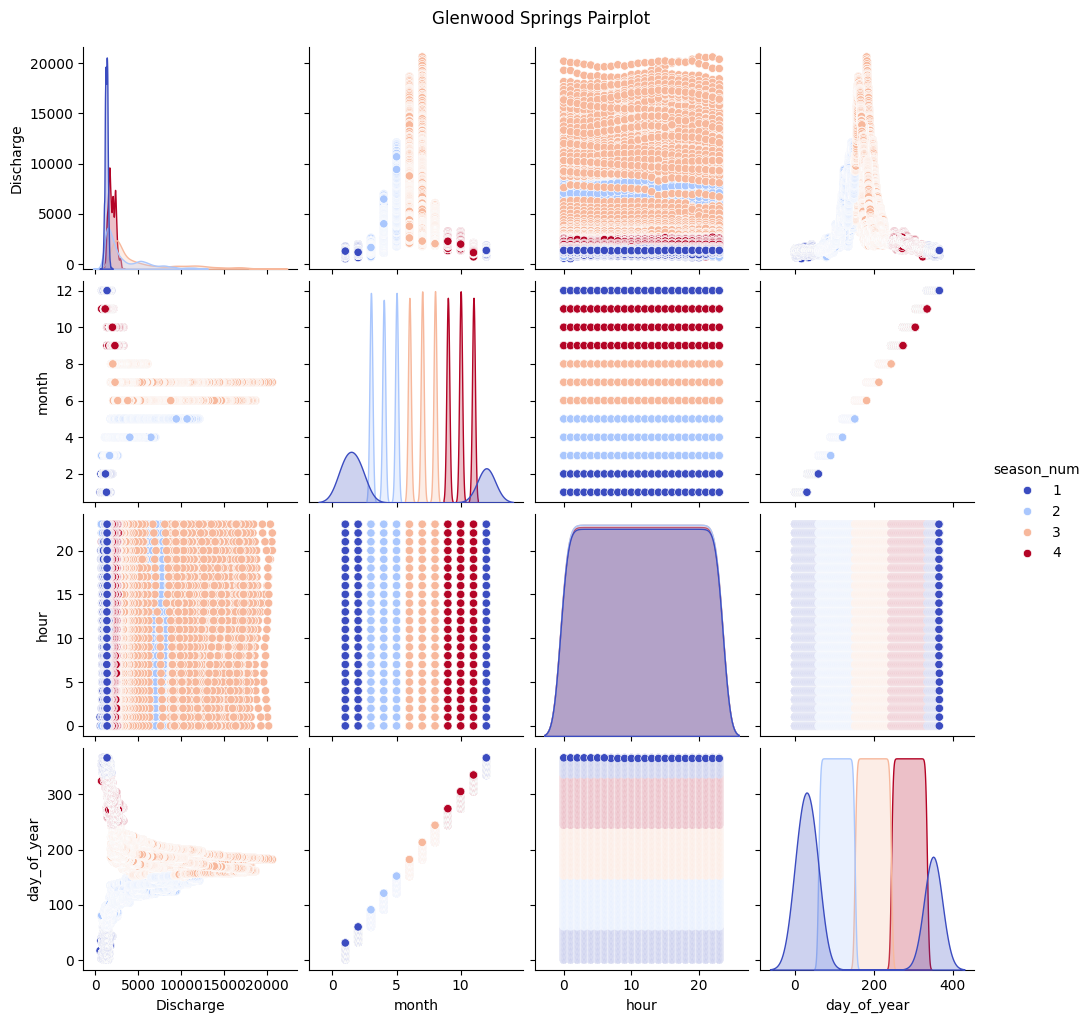

In [12]:
features = ["Discharge", "month", "hour", "season_num", "day_of_year"]
sns.pairplot(gs_df[features], hue="season_num", palette="coolwarm")
plt.suptitle("Glenwood Springs Pairplot", y=1.02)
plt.show()

**Figure 4.** Pairplot for Glenwood Springs site over different temporal seasons. Summer, specifically june and july, sees the highest discharge rates. There is also a slight hourly pattern.

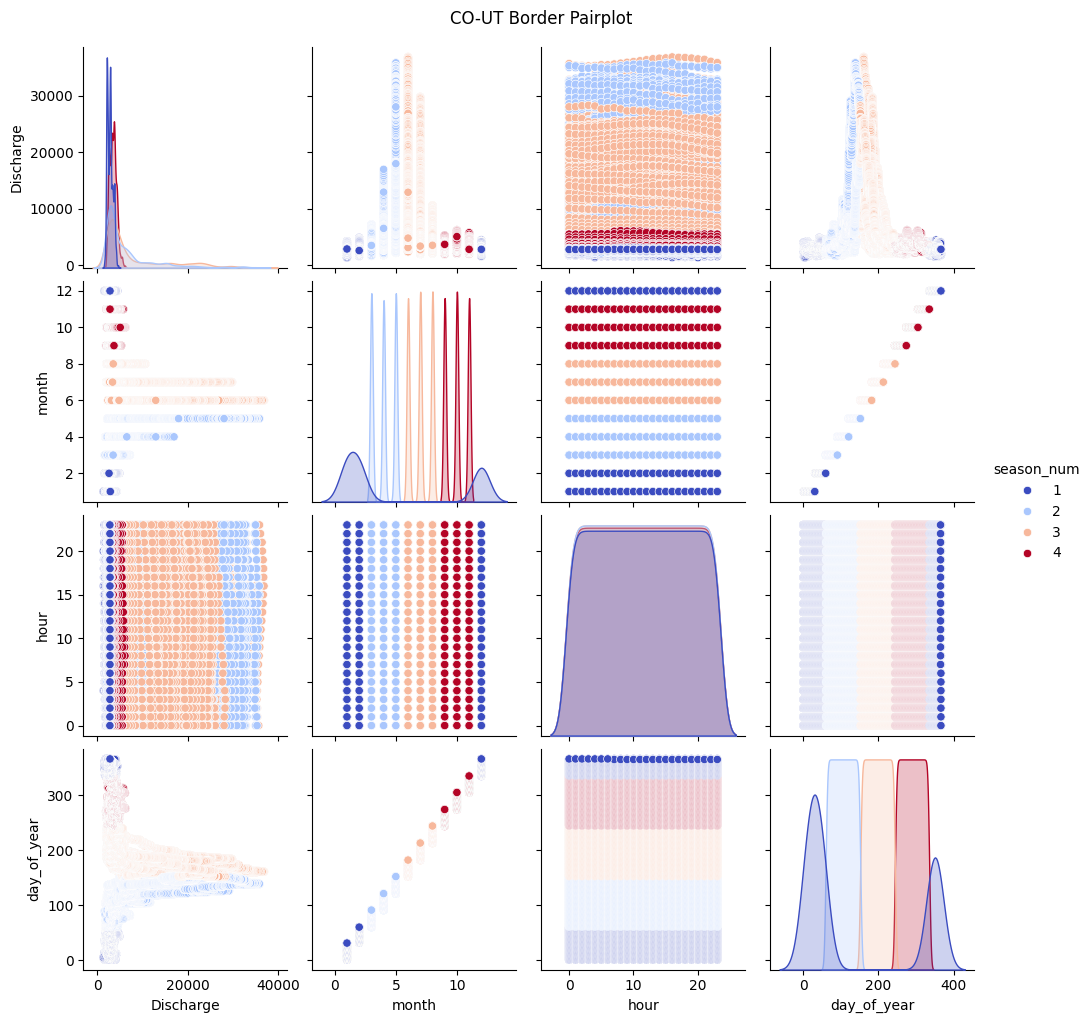

In [13]:
sns.pairplot(cu_df[features], hue="season_num", palette="coolwarm")
plt.suptitle("CO-UT Border Pairplot", y=1.02)
plt.show()

**Figure 5.** Pairplot for Colorado-Utah border site. May, june, and july see the highest discharge rates.

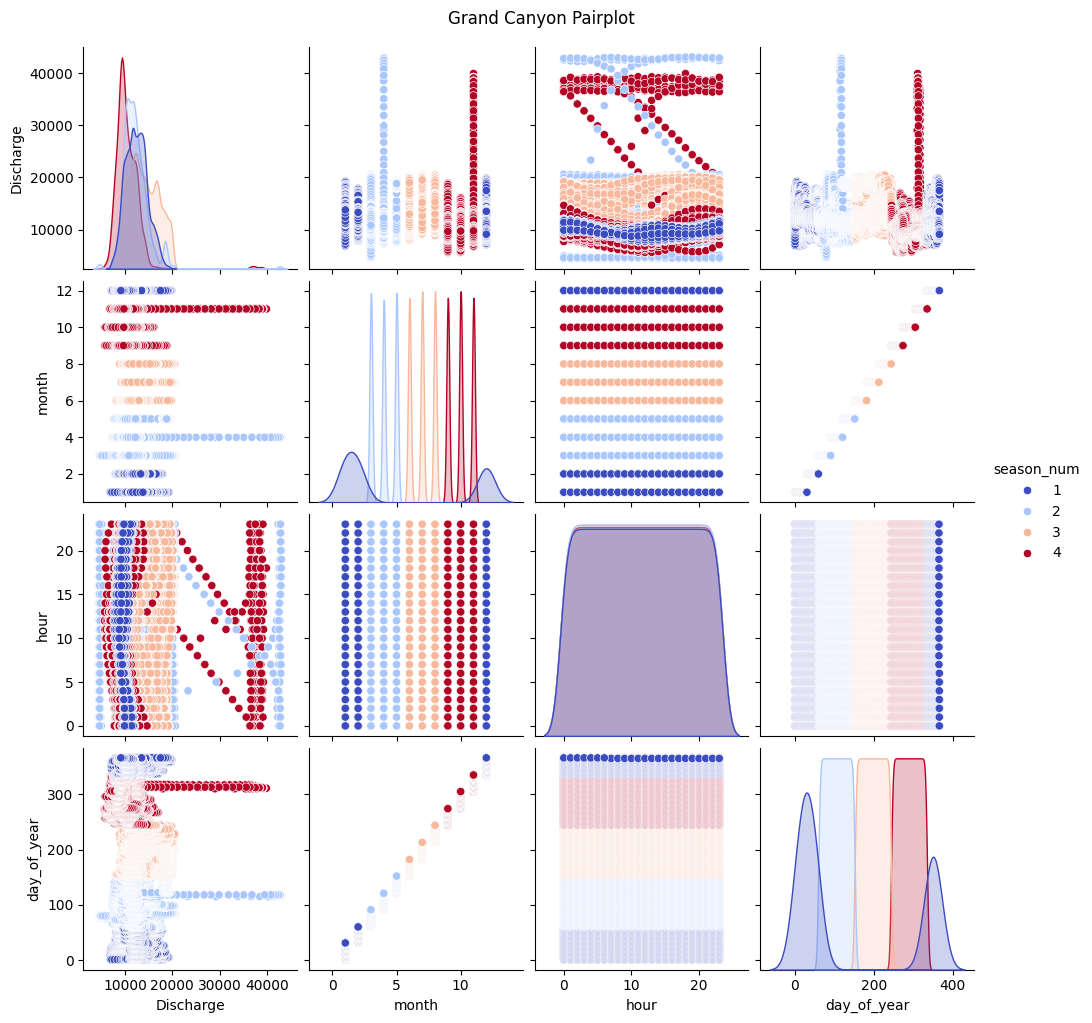

In [14]:
sns.pairplot(gc_df[features], hue="season_num", palette="coolwarm")
plt.suptitle("Grand Canyon Pairplot", y=1.02)
plt.show()

**Figure 6.** Pairplot of Grand Canyon site. Daily variation is a bit more noticeable. The two high rate outliers make it difficult to notice but discharge rates rise in winter and summer and are lower in spring and fall.

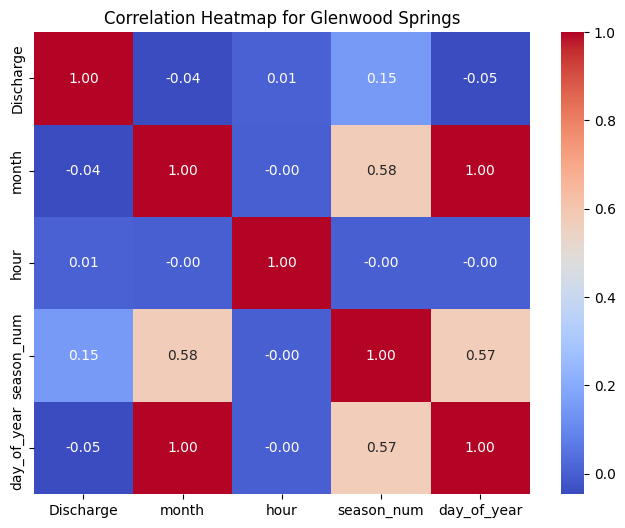

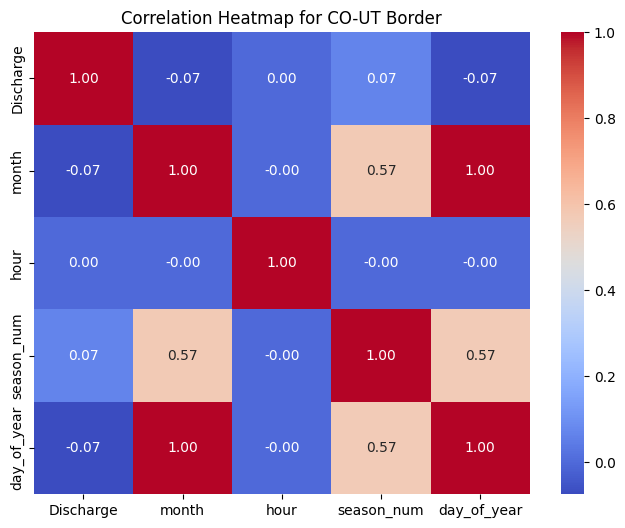

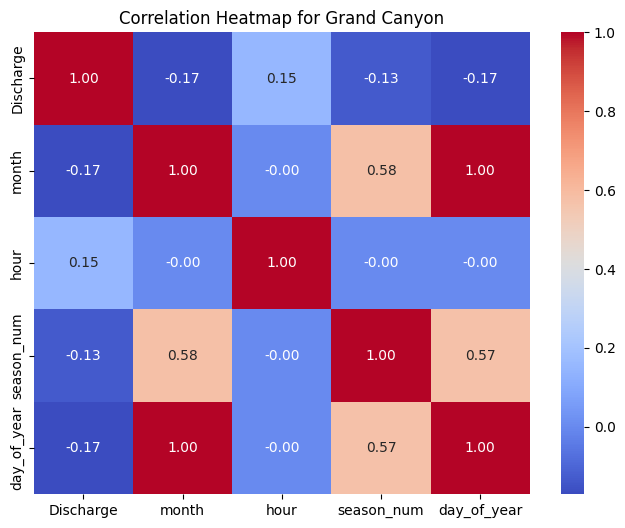

In [15]:
features = ["Discharge", "month", "hour", "season_num", "day_of_year"]
site_dfs = {'Glenwood Springs': gs_df,
            'CO-UT Border': cu_df,
            'Grand Canyon': gc_df}

for site_name, site_df in site_dfs.items():
    # Calculate the correlation matrix
    corr_matrix = site_df[features].corr()

    # Create the heatmap
    plt.figure(figsize=(8, 6))  # Adjust figsize as needed
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Heatmap for {site_name}')
    plt.show()

**Figure 7.** Correlation heatmaps for each site.

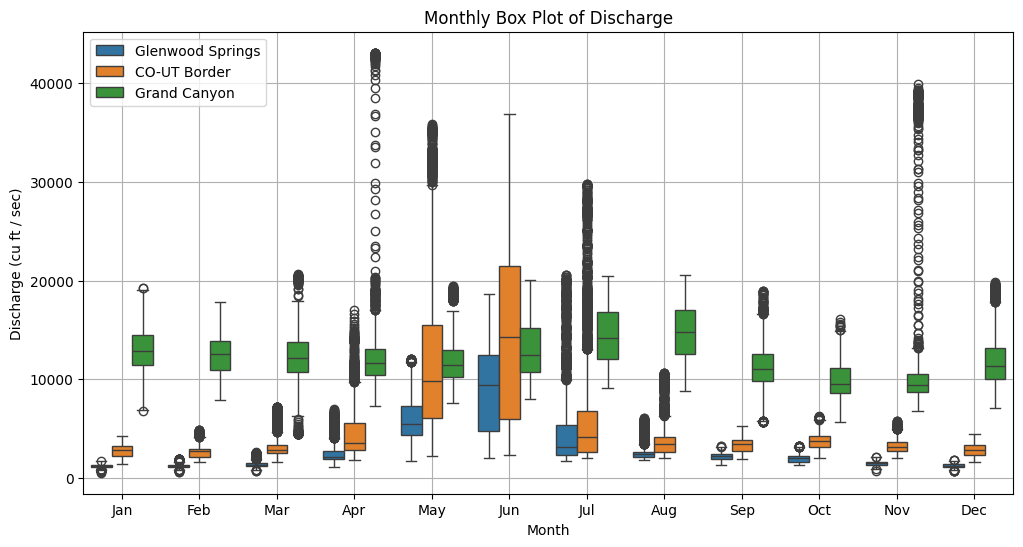

In [16]:
plt.figure(figsize=(12, 6))
data = []
for site_name, site_df in site_dfs.items():
    data.extend([[site_name, month, discharge]
                 for month, discharge in zip(site_df.index.month, site_df['Discharge'])])

# Create a DataFrame from the data
df_boxplot = pd.DataFrame(data, columns=['Site', 'Month', 'Discharge'])

# Create the box plot using Seaborn
sns.boxplot(x='Month', y='Discharge', hue='Site', data=df_boxplot)
plt.title('Monthly Box Plot of Discharge')
plt.xlabel('Month')
plt.ylabel('Discharge (cu ft / sec)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set x-axis labels
plt.grid(True)
plt.legend()
plt.show()

**Figure 8.** The final few plots of this EDA are boxplots for different seasonal variations. This one shows monthly variations. Glenwood and CO-UT see highest discharge, and with the most variation, in June. Grand Canyon  discharge rates rise high in june through august then steeply decrease before increasing again slightly in december.

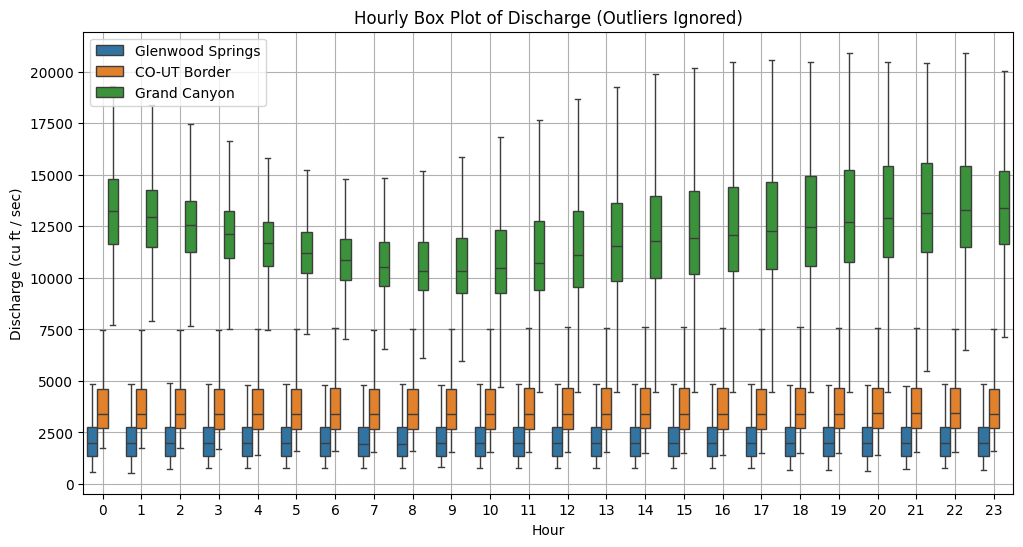

In [17]:
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Create a list to store the data for the box plots
data = []
for site_name, site_df in site_dfs.items():
    data.extend([[site_name, hour, discharge]
                 for hour, discharge in zip(site_df.index.hour, site_df['Discharge'])])

# Create a DataFrame from the data
df_boxplot = pd.DataFrame(data, columns=['Site', 'Hour', 'Discharge'])

# Create the box plot using Seaborn
sns.boxplot(x='Hour', y='Discharge', hue='Site', data=df_boxplot, showfliers=False)
plt.title('Hourly Box Plot of Discharge (Outliers Ignored)')
plt.xlabel('Hour')
plt.ylabel('Discharge (cu ft / sec)')
plt.xticks(range(24))  # Set x-axis labels for each hour
plt.grid(True)
plt.legend()
plt.show()

**Figure 9.** Boxplot of discharge by each hour. The Grand Canyon site has the most variation throughout the day. Evenings have higher rates while mornings are lower. There are no noticeable variations in the other two sites.

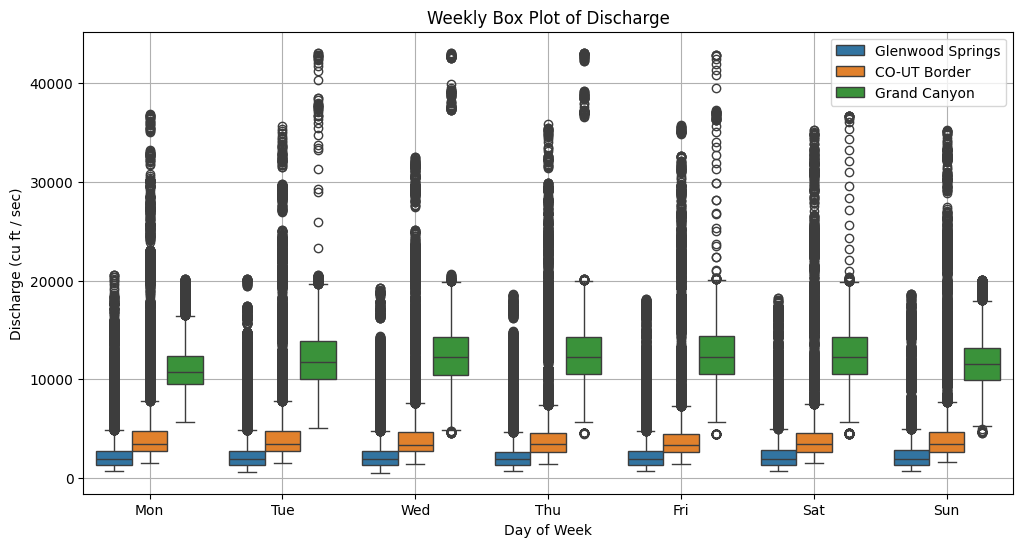

In [18]:
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Create a list to store the data for the box plots
data = []
for site_name, site_df in site_dfs.items():
    data.extend([[site_name, dayofweek, discharge]
                 for dayofweek, discharge in zip(site_df.index.dayofweek, site_df['Discharge'])])

# Create a DataFrame from the data
df_boxplot = pd.DataFrame(data, columns=['Site', 'DayofWeek', 'Discharge'])

# Create the box plot using Seaborn
sns.boxplot(x='DayofWeek', y='Discharge', hue='Site', data=df_boxplot)
plt.title('Weekly Box Plot of Discharge')
plt.xlabel('Day of Week')
plt.ylabel('Discharge (cu ft / sec)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # Set x-axis labels for each day of the week
plt.grid(True)
plt.legend()
plt.show()

**Figure 10.** Boxplot of discharge by day of the week. Grand Canyon site shows slight variation by day with wednesday through saturday equally having the highest averages.

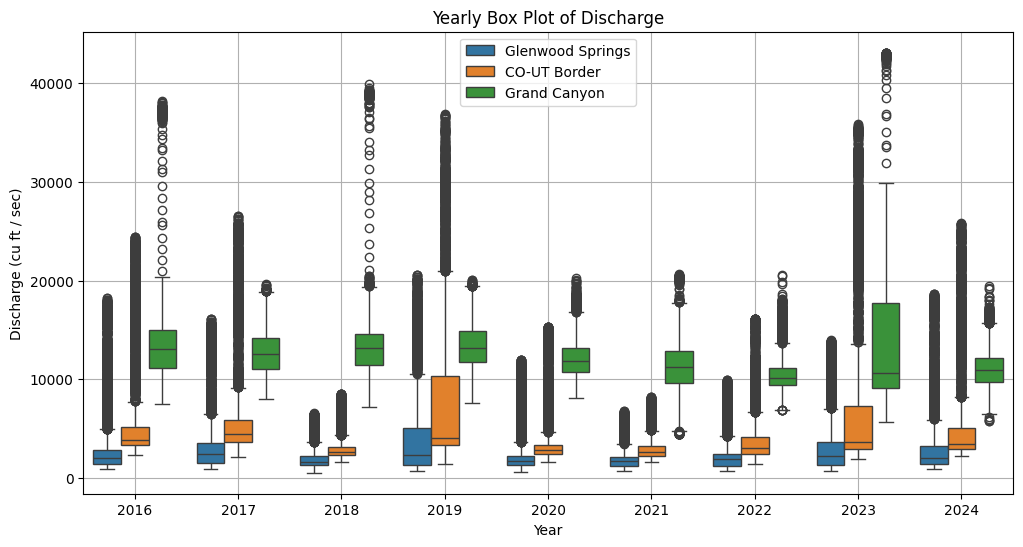

In [19]:
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Create a list to store the data for the box plots
data = []
for site_name, site_df in site_dfs.items():
    data.extend([[site_name, year, discharge]
                 for year, discharge in zip(site_df.index.year, site_df['Discharge'])])

# Create a DataFrame from the data
df_boxplot = pd.DataFrame(data, columns=['Site', 'Year', 'Discharge'])

# Create the box plot using Seaborn
sns.boxplot(x='Year', y='Discharge', hue='Site', data=df_boxplot)
plt.title('Yearly Box Plot of Discharge')
plt.xlabel('Year')
plt.ylabel('Discharge (cu ft / sec)')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed for better readability
plt.grid(True)
plt.legend()
plt.show()

**Figure 11.** Boxplot of discharge by year. Explored further below.

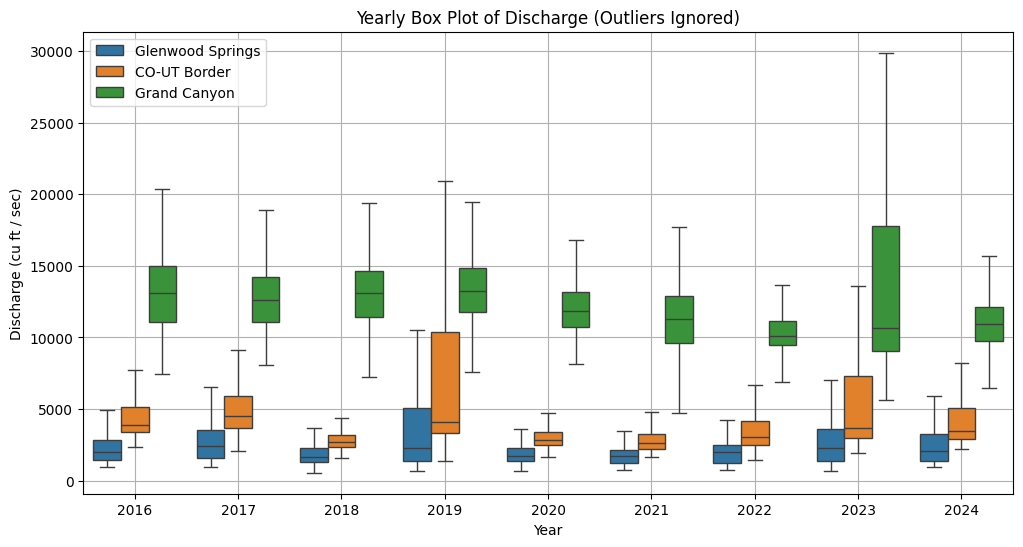

In [20]:
plt.figure(figsize=(12, 6))  # Adjust figsize as needed

# Create a list to store the data for the box plots
data = []
for site_name, site_df in site_dfs.items():
    data.extend([[site_name, year, discharge]
                 for year, discharge in zip(site_df.index.year, site_df['Discharge'])])

# Create a DataFrame from the data
df_boxplot = pd.DataFrame(data, columns=['Site', 'Year', 'Discharge'])

# Create the box plot using Seaborn
sns.boxplot(x='Year', y='Discharge', hue='Site', data=df_boxplot, showfliers=False)
plt.title('Yearly Box Plot of Discharge (Outliers Ignored)')
plt.xlabel('Year')
plt.ylabel('Discharge (cu ft / sec)')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed for better readability
plt.grid(True)
plt.legend()
plt.show()

**Figure 11.** Boxplot of discharge by year but without the outliers for easier analysis. 2019 saw atypical discharge rates for Glenwood and Colorado-Utah sites. These sites aslo experienced slight yearly increase of discharge rates from 2020 to 2024. 2023 saw atypical discharge for all 3 but especially the Grand Canyon site. This site saw a slight rise till 2019 and then descent till 2023.